<a href="https://colab.research.google.com/github/tripatheea/auto/blob/main/just_posterior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install tensorflow-probability

# to generate gifs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-sqgr8bea
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-sqgr8bea
  Resolved https://github.com/tensorflow/docs to commit 8f431e2b96ebbebd325a7162a00c40653af799e5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=3d8c6abc8bc701d01c0b506d2f599b7974871f77ef7c908dd1653ccfb1b40c3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-4gkk74px/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution

In [4]:
# import keras
# from keras import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Dense, Lambda, Flatten
# from keras import backend as K

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import glob
import skimage
import skimage.transform
import skimage.io
import PIL
import numpy as np
import os
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import imageio
# import utils

In [235]:
! pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [236]:
import corner

In [5]:
enable_eager_execution()

In [510]:
WIDTH = 48

In [978]:
import numpy as np
import matplotlib.pyplot as plt

import time
from tensorflow.keras import regularizers
import tensorflow.keras.initializers

def	MakeSpectrogram(f_sig = 100., bandwidth = 0.25, Tobs_hr = 24., Tcoh_hr = .25, 
		hnoise = 100., hamp = .4, fsamp = 512., fdot_sig = -1e-6, 
		plot_num = 0, plot = False, write_to_file = False):
	
	##### Defining Variables #####
	# f_sig     --- signal central frequency, hz
	# bandwidth --- bandwidth of search, width of each freq, hz
	# Tobs_hr   --- Length of observation, hrs
	# Tcoh_hr   --- Coherence time, hrs
	# hnoise    --- noise amplitude
	# hamp      --- signal amplitude
	# fsamp     --- sampling frequency, hz
	# fdot_sig  --- Signal frequency derivative 
	# plot_num  --- if multiple files is an index
	# whereto   --- Where to save plot
	
	##### Booleans ####
	# plot      	--- whether or not to plot
	# write_to_file --- whether to save data to .txt file

	#### Returns ####
	# frequency 
	# time
	# spectrogram

	# Define constants
	SECS_PER_HOUR = 3600
	
	# Find amplitude spectral density for noise
	noiseamp = hnoise*np.sqrt(4./fsamp) 
	
	
	# Convert observation and coherence time to seconds
	Tobs = Tobs_hr * SECS_PER_HOUR
	Tcoh = Tcoh_hr * SECS_PER_HOUR

	# Find low and high frequency
	freqlo_approx = f_sig - 0.5 * bandwidth
	freqlo = np.floor(freqlo_approx * Tcoh) / Tcoh
	freqhi = freqlo + bandwidth

	# Define time series to hold raw data stream of signal + noise
	deltat = 1. / fsamp
	t = np.arange(0,Tobs,deltat)
	Nsample = len(t)
	# print ('Nsample = %i'%len(t))
	
	# Generate signal in the time domain
	noise = noiseamp * np.random.normal(0, scale = 1, size = (Nsample,))
	signal = hamp * np.sin(2 * np.pi * (f_sig * t + .5 * fdot_sig * t**2))

	data = signal + noise

	# Generate spectra for each coherence time & extract band of interest to make spectrogram
	indbandlo = int(np.floor(freqlo * Tcoh))
	indbandhi = int(np.floor(freqhi * Tcoh))
	nbandbin  = indbandhi - indbandlo
	Nseg = int(np.floor(Tobs / Tcoh))
	Nsample_coh = int(np.floor(Nsample / Nseg))
	spectrogram = np.zeros((nbandbin,Nseg),)	
	# print( np.shape(spectrogram) )
	
	for seg in range(Nseg):
		# print('Generating segment %d\n'%(seg))
		indlo = seg * Nsample_coh
		indhi = indlo + Nsample_coh 
		segment = data[indlo:indhi]
		
		rawfft = np.fft.fft(segment,Nsample_coh, axis = 0)
		spectrogram[:,seg] = 2 * abs(rawfft[indbandlo:indbandhi])
		
	segarray = np.arange(0,Nseg)
	seghour = (segarray) * Tcoh / SECS_PER_HOUR
	indarray = np.arange(indbandlo,indbandhi + 1)
	freqplot = (indarray - indbandlo)*1.0/Tcoh + freqlo	
  
	if plot:
		plt.clf()
		# print('Plotting spectrogram')
		
		plt.pcolormesh(seghour, freqplot, spectrogram)
		plt.ylabel('Frequency [Hz]')
		plt.xlabel('Time [Hours]')
  
  
	return(seghour, freqplot, spectrogram)



In [984]:
def fix_dims_and_normalize(s):
  
  s = np.pad(s, ((0, WIDTH - s.shape[0]), (0, WIDTH - s.shape[1])))

  # return (s - np.min(s)) / (np.max(s) - np.min(s))
  return s

In [985]:
bandwidth = 0.054
f_sig = 3

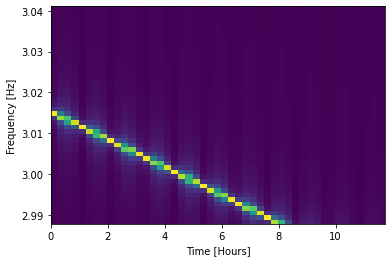

In [986]:
t, f, spec = MakeSpectrogram(f_sig = np.random.uniform(f_sig - 0.5 * bandwidth, f_sig + 0.5 * bandwidth), bandwidth = bandwidth, Tobs_hr = 12., Tcoh_hr = .25, 
              hnoise = np.random.uniform(0.0, 0.001), hamp = np.random.uniform(0.1, 0.5), fsamp = 128., fdot_sig = np.random.choice([-1, 1]) * 10**np.random.uniform(-6, -7), 
              plot_num = 0, plot = True, write_to_file = False)

In [987]:
spec.shape

(48, 48)

i = 0
(50, 48, 48)


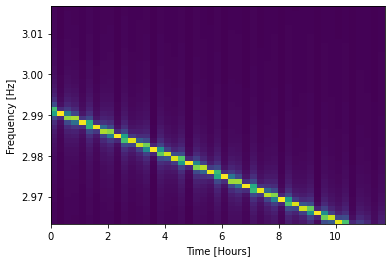

In [992]:
all_specs = []
N = 50

x_s = []
for i in range(N):
  # t, f, spec = MakeSpectrogram(f_sig = np.random.random() * 100., bandwidth = 0.05, Tobs_hr = 12., Tcoh_hr = .25, 
  #             hnoise = 100. + (1 - 2 * np.random.random() * 10.), hamp = .4, fsamp = 128., fdot_sig = -1e-6, 
  #             plot_num = 0, plot = True, write_to_file = False)
  freq = np.random.uniform(f_sig - 0.5 * bandwidth, f_sig + 0.5 * bandwidth)
  spindown = np.random.choice([-1, 1]) * 10**np.random.uniform(-6, -7)
  t, f, spec = MakeSpectrogram(f_sig = freq, bandwidth = bandwidth, Tobs_hr = 12., Tcoh_hr = .25, 
            hnoise = np.random.uniform(0.0, 0.001), hamp = np.random.uniform(0.1, 0.5), fsamp = 128., fdot_sig = spindown, 
            plot_num = 0, plot = True, write_to_file = False)
  
  scaler = StandardScaler()
  spec = scaler.fit_transform(spec)

  r = fix_dims_and_normalize(np.copy(spec))

  # print(r.shape)
  all_specs.append(r)
  x_s.append((freq, spindown))

  if (i % 100) == 0:
    print(f"i = {i}")

all_specs = np.asanyarray(all_specs)

size = len(all_specs)

print(all_specs.shape)

In [993]:
all_specs[0,:,:]

array([[-0.43672241, -0.27700236, -0.29579761, ..., -0.391726  ,
        -0.17269804, -0.39971669],
       [-0.43230967, -0.27515724, -0.29374864, ..., -0.39039688,
        -0.17262672, -0.39836792],
       [-0.42757204, -0.27312454, -0.29152388, ..., -0.38898159,
        -0.17259494, -0.39693052],
       ...,
       [-0.41753595, -0.26652834, -0.28204037, ..., -0.05474888,
        -0.15306035,  0.01208701],
       [-0.42321797, -0.26912672, -0.28506756, ..., -0.11654341,
        -0.15809837, -0.07053158],
       [-0.42845155, -0.27143207, -0.28783626, ..., -0.16140054,
        -0.16119663, -0.1282054 ]])

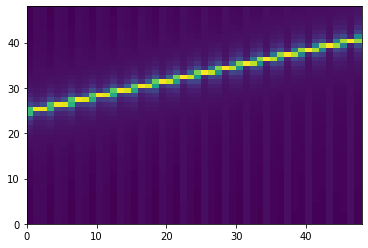

In [994]:
plt.pcolormesh(all_specs[0,:,:])

In [995]:
# all_specs

In [996]:
x_s = np.asanyarray(x_s)

x_s.shape

(50, 2)

In [997]:
from sklearn.preprocessing import StandardScaler

In [998]:
x_scaler = StandardScaler()
scaled_x_s = x_scaler.fit_transform(x_s)

In [1001]:
# scaled_x_s

In [900]:
from sklearn.model_selection import train_test_split

In [1002]:
# x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_s, all_specs, test_size=0.2, random_state=42)

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(scaled_x_s, all_specs, test_size=0.2, random_state=42)
x_test_s, x_val_s, y_test_s, y_val_s = train_test_split(x_test_s, y_test_s, test_size=0.5, random_state=26)

x_train_s.shape

(40, 2)

In [1003]:
x_train_s = np.expand_dims(x_train_s, -1)
x_test_s = np.expand_dims(x_test_s, -1)
x_val_s = np.expand_dims(x_val_s, -1)

y_train_s = np.expand_dims(y_train_s, -1)
y_test_s = np.expand_dims(y_test_s, -1)
y_val_s = np.expand_dims(y_val_s, -1)

x_train_s.shape

(40, 2, 1)

In [1004]:
def convert_to_tensor_utility(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

 
x_train_s, y_train_s, x_test_s, y_test_s, x_val_s, y_val_s = tuple(map(convert_to_tensor_utility, [x_train_s, y_train_s, x_test_s, y_test_s, x_val_s, y_val_s]))

In [1005]:
x_train_s.shape, y_train_s.shape

(TensorShape([40, 2, 1]), TensorShape([40, 48, 48, 1]))

In [1006]:
y_train_s.shape, y_test_s.shape, y_val_s.shape

(TensorShape([40, 48, 48, 1]),
 TensorShape([5, 48, 48, 1]),
 TensorShape([5, 48, 48, 1]))

In [1014]:
# y_train_s

In [1015]:
batch_size = 8

In [1016]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_s, y_train_s)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_s, y_test_s)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_s, y_val_s)).batch(batch_size)

In [1017]:
params = dict()

params['z_dim'] = 32
params['n_modes'] = 1
params['n_channels'] = 1
params['ramp_start'] = 10
params['ramp_end'] = 20
params['y_normscale'] = 1.0

params['rand_pars'] = ['frequency', 'fdot']
params['inf_pars'] = ['frequency', 'fdot']


In [1018]:
def ramp_func(epoch,start,ramp_length, n_cycles):
    i = (epoch - start) / (2.0 * ramp_length)
    print(epoch,i)
    
    if i < 0:
        return 0.0
    if i >= n_cycles:
        return 1.0
    
    return min(1.0, 2.0 * np.remainder(i, 1.0))

optimizer = tf.keras.optimizers.Adam(1e-4)
initializer = tf.keras.initializers.GlorotUniform()

In [1019]:
def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = tf.keras.layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers..BatchNormalization(name='bn_1')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    return x

SyntaxError: ignored

In [1020]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, x_dim, y_dim, n_channels, z_dim, n_modes, params):
        super(CVAE, self).__init__()
        self.z_dim = z_dim
        self.n_modes = n_modes
        self.x_modes = 1   # hardcoded for testing
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_channels = n_channels
        self.act = tf.keras.layers.LeakyReLU(alpha=0.01)
        self.params = params
        self.reg = regularizers.l2(0.001)


        start_filters = 8

        """
        # Add this to get rid of regularizer
        a2 = tf.keras.layers.Dense(2*self.z_dim*self.n_modes + self.n_modes)(a2)
        self.encoder_r1 = tf.keras.Model(inputs=r1_input_y, outputs=a2)
        print(self.encoder_r1.summary())
        """
        
        # the r1 encoder network- r1_encoder(y) = z'.

        r1_input_y = tf.keras.Input(shape=(WIDTH, WIDTH, 1))

        eblock1 = define_encoder_block(r1_input_y, start_filters)
        eblock2 = define_encoder_block(eblock1, start_filters*2)
        eblock3 = define_encoder_block(eblock2, start_filters*4)
        eblock4 = define_encoder_block(eblock3, start_filters*8)
        eblock4 = define_encoder_block(eblock4, start_filters*8)
        # eblock4 = eblock2
        _, *shape_spatial = eblock4.get_shape().as_list()
        eblock4_flat = tf.keras.layers.Flatten()(eblock4)

        x = tf.keras.layers.BatchNormalization(name='bn_2')(eblock4_flat)
        a2 = tf.keras.layers.Dense(32, kernel_regularizer=self.reg, activation=self.act)(x)
        a2 = tf.keras.layers.Dropout(.1)(a2)
        a2 = tf.keras.layers.Dense(32, kernel_regularizer=self.reg, activation=self.act)(a2)
        a2 = tf.keras.layers.Dropout(.5)(a2)
        a2 = tf.keras.layers.Dense(16, kernel_regularizer=self.reg, activation=self.act)(a2)
        a2 = tf.keras.layers.BatchNormalization(name='bn_3')(a2)
        a2 = tf.keras.layers.Dense(2*self.z_dim*self.n_modes + self.n_modes)(a2)
        self.encoder_r1 = tf.keras.Model(inputs=r1_input_y, outputs=a2)

        print(self.encoder_r1.summary())


        # the q encoder network- q_encoder(x, y) = z''.

        q_input_x = tf.keras.Input(shape=(self.x_dim))
        c = tf.keras.layers.Flatten()(q_input_x)
        d = tf.keras.layers.concatenate([eblock4_flat, c])
        d = tf.keras.layers.BatchNormalization(name='bn_4')(d)
        e = tf.keras.layers.Dense(32, kernel_regularizer=self.reg, activation=self.act)(d)
        e = tf.keras.layers.Dropout(.1)(e)
        e = tf.keras.layers.Dense(32, kernel_regularizer=self.reg, activation=self.act)(e)
        e = tf.keras.layers.Dropout(.5)(e)
        e = tf.keras.layers.Dense(16, kernel_regularizer=self.reg, activation=self.act)(e)
        e = tf.keras.layers.BatchNormalization(name='bn_5')(e)
        e = tf.keras.layers.Dense(2*self.z_dim)(e)
        self.encoder_q = tf.keras.Model(inputs=[r1_input_y, q_input_x], outputs=e)


        print(self.encoder_q.summary())


        # the r2 decoder network- r2_decoder(y, z) = x'.

        r2_input_z = tf.keras.Input(shape=(self.z_dim))
        g = tf.keras.layers.Flatten()(r2_input_z)
        h = tf.keras.layers.concatenate([eblock4_flat, g])
        h = tf.keras.layers.BatchNormalization(name='bn_6')(h)
        i = tf.keras.layers.Dense(32, kernel_regularizer=self.reg, activation=self.act)(h)
        i = tf.keras.layers.Dropout(.1)(i)
        i = tf.keras.layers.Dense(32, kernel_regularizer=self.reg, activation=self.act)(i)
        i = tf.keras.layers.Dropout(.5)(i)
        i = tf.keras.layers.Dense(16, kernel_regularizer=self.reg, activation=self.act)(i)
        i = tf.keras.layers.BatchNormalization(name='bn_7')(i)
        j = tf.keras.layers.Dense(2*self.x_dim*self.x_modes + self.x_modes)(i)
        self.decoder_r2 = tf.keras.Model(inputs=[r1_input_y, r2_input_z], outputs=j)

        print(self.decoder_r2.summary())
        # During use, we would only have y. Use r1_encoder(y) = z'. Then, use r2_decoder(y, z') = x' to get the prediction / posterior.
    
    def get_encoders(self):
        return self.encoder_r1, self.encoder_q
    
    def encode_r1(self, y=None):
#         print("==")
#         print(y)
#         print("AAA")
#         print(self.encoder_r1(y).shape)
#         print(self.encoder_r1(y))
# #         print([self.z_dim*self.n_modes, self.z_dim*self.n_modes,self.n_modes])
#         print("==")
#         print(self.z_dim*self.n_modes + self.z_dim*self.n_modes + self.n_modes)
        
#         mean, logvar, weight = tf.split(self.encoder_r1(y), num_or_size_splits=[2, 4, 3], axis=1)

        encoded_y = self.encoder_r1(y)  # (4, 17)

        # print(encoded_y.shape)
        mean, logvar, weight = tf.split(encoded_y, num_or_size_splits=[self.z_dim*self.n_modes, self.z_dim*self.n_modes,self.n_modes], axis=1)
        
        # print(mean.shape, logvar.shape, weight.shape) # (4, 8), (4, 8), (4, 1)
        
        # Becomes (4, 1, 2) (4, 2, 1)
        return tf.reshape(mean,[-1,self.n_modes,self.z_dim]), tf.reshape(logvar,[-1,self.n_modes,self.z_dim]), tf.reshape(weight,[-1,self.n_modes])


    def encode_q(self, x=None, y=None):
        return tf.split(self.encoder_q([y,x]), num_or_size_splits=[self.z_dim, self.z_dim], axis=1)

    def decode_r2(self, y=None, z=None, apply_sigmoid=False):
        
#         print("AA", self.decoder_r2([y, z]).shape)
#         print("BB", [2 * self.x_dim * self.x_modes, self.x_modes])
        mean, logvar, weight = tf.split(self.decoder_r2([y, z]), num_or_size_splits=[self.x_dim*self.x_modes, self.x_dim*self.x_modes, self.x_modes], axis=1)
        return tf.reshape(mean,[-1,self.x_modes,self.x_dim]), tf.reshape(logvar,[-1,self.x_modes,self.x_dim]), tf.reshape(weight,[-1,self.x_modes])

In [1021]:
EPS = 1e-3
dist_mask = np.array([True])
not_dist_mask = np.array([True])

bounds = dict(a=0.0, b=30.0)


# KL[P || Q] = S(P) - H(P, Q)               Model P with approximation Q.
# KL[Q || P] = S(Q) - H(Q, P)               Model Q with approximation P.

# Variational Autoencoders:
#  Let X be the data we want to model, z is the latent variable. Pr[X] = distn of data. Pr[z] latent distrn. Pr[X | z] = distrn of generating data | latent variable.
#  We want to infer Pr[z] from Pr[z | X] which is the distrn that projects our data into the latent space.  
#  But we do not know Pr[z | X], so we use a simpler estimate of Qr[z | X].

# KL( Qr[z | X] || Pr[z | X] ) = E{ log( Qr[z | X] ) - log( Pr[z | X] ) } summed up over Qr[z | X]. 
# KL = H(Q, P) - S(Q) = cross-entropy between Q and P - entropy of P => info in just P - info overlap between P and Q => remaining info in P that we missed. 


# Ingredients:
#   - Qr[z | x]
#   - 

# Infer z_mean, z_var from just y.               Use encoder r1._samp            A = Pr[z | y].
# 
# Infer z'_mean', z'_var' from x, y to get z_sample.                        B = Pr[z | x, y] => sample z_samp from q. We later calculate self-entropy of this.
# Use encoder q for this.  Qr[z_sample | x, y]. Calculate self-entropy.
# C = Pr[z_samp | y] = x_samp.
# 
# Pr[z | x, y] is the "real" / actual distribution. So we want self-entropy of that - cross-entropy of that with Pr[z_samp | y].
# What we are doing is that we are looking at how much information we are missing by calculating z_samp using Pr[z | y] instead of the actual distribution
# of Pr[z | x, y]. This gives us our KL divergence, which we want to minimize.


# Decode (z_sample, y) to get a distribution for x. Pr[x | z_samp, y]. Then, calculate the probability of getting x_actual under this distribution (log-likelihood).
# The higher the probability the better it is, which we want to maximize.

# Total Loss = (2) - (1)




# XXXXX
# Calculate self-entropy with Pr[z_samp] from inference of z_mean with y i.e. Pr[z_mean | y].  So entropy of Pr[z | x, y]. 
# This is the real distribution P. We are approximating it with Qr[z | y]. So we want S[ Pr[z | x, y] ] - H[Pr[z|x,y], Pr[z|y]].
# Pr[z_samp] under A / r1.

# 

tfd = tfp.distributions

def compute_loss(model, x, y, ramp=1.0, noiseamp=1.0):
    
#     print("Computing loss.")
    
    old_old_x = x
    
    noiseamp = tf.cast(noiseamp, dtype=tf.float32)
    y_normscale = tf.cast(params['y_normscale'], dtype=tf.float32)
#     y = tf.cast(y, dtype=tf.float32)
#     x = tf.cast(x, dtype=tf.float32)
    
#     y = (y + noiseamp*tf.random.normal(shape=tf.shape(y), mean=0.0, stddev=1.0, dtype=tf.float32))
    
    # print("x", x)
    
    # print("y", y)
    
    # This is in the latent space z. z just from y.
    mean_r1, logvar_r1, logweight_r1 = model.encode_r1(y=y)             # Infer z_mean, z_var by encoding y.
    
    
    
    
    scale_r1 = EPS + tf.sqrt(tf.exp(logvar_r1))                         # Fix to enable backpropagation.

    # Sample from the latent space. z just from y.
    gm_r1 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r1),
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r1,
            scale_diag=scale_r1))
    
    # Latent space. z from x and y.
    mean_q, logvar_q = model.encode_q(x=x, y=y)                         # Infer z'_mean and z'_var by encoding x and y.
    scale_q = EPS + tf.sqrt(tf.exp(logvar_q))                           # Fix to enable backpropagation.
    
    
    
    # print(np.mean(mean_r1))
    
    # Sample from the latent space. z from x and y.
    mvn_q = tfp.distributions.MultivariateNormalDiag(
                          loc=mean_q,
                          scale_diag=scale_q)
    
    z_samp = mvn_q.sample()                                               # Sample z_samp from a multi-variate normal distribution (inferred from (x, y)).
    
    # print(z_samp)
    # Take the latent sample and y to reconstruct x. Pr[x | y, z]
    mean_r2, logvar_r2, logweight_r2 = model.decode_r2(y=y, z=z_samp)     # Decode (z_samp, y) to get predicted x'.
    scale_r2 = EPS + tf.sqrt(tf.exp(logvar_r2))
    
    # This is a sample from x.
    # print("Drawn f = ", np.mean(mean_r2), end=", ")
    
    # Distribution for x. Pr[x | y, z]
    gm_r2 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r2),      # Sample predicted x'.
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r2,
            scale_diag=scale_r2))
    

    # print(mean_r2.shape, old_old_x.shape)
    
    simple_cost_recon = -1.0*tf.reduce_mean(gm_r2.log_prob(old_old_x))                            # Calculate the odds of having the x_actual. Pr[x | y, z_samp].

    # print(simple_cost_recon)
    
    selfent_q = -1.0*tf.reduce_mean(mvn_q.entropy())                                         # Self-entropy of q-encoder [(x, y) => z_samp]. H(z_samp(x, y)).
    log_r1_q = gm_r1.log_prob(z_samp)   # evaluate the log prob of r1 at the q samples       # Pr[z_samp | x, y].
    cost_KL = selfent_q - tf.reduce_mean(log_r1_q)                                           # KL-div with self-entropy - cross-entropy.
    
    # KL = H(z_samp(x, y)) - Pr[z_samp | x, y].
    
    
    return simple_cost_recon, cost_KL

In [1022]:
train_loss_metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

@tf.function
def train_step(model, x, y, optimizer, ramp=1.0):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    
    
    ramp = 1.0
    
    with tf.GradientTape() as tape:
        r_loss, kl_loss = compute_loss(model, x, y, ramp=ramp)
        # r_loss, kl_loss = compute_loss(model, x, y)
        loss = r_loss + ramp * kl_loss
        
    gradients = tape.gradient(loss, model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss_metric(loss)
    
    return r_loss, kl_loss

In [1023]:
tf.random.set_seed(42)
np.random.seed(42)


epochs = 50

# start the training loop
train_loss = np.zeros((epochs, 2))
test_loss = np.zeros((epochs, 2))
ramp_start = params['ramp_start']
ramp_length = params['ramp_end']


ramp_cycles = 1
KL_samples = []



model = CVAE(x_dim=2, y_dim=1, n_channels=params['n_channels'], \
             z_dim=params['z_dim'], n_modes=1, params=params)

model.compile()

Model: "model_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_105 (InputLayer)      [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_287 (Conv2D)         (None, 48, 48, 8)         80        
                                                                 
 conv2d_288 (Conv2D)         (None, 48, 48, 8)         584       
                                                                 
 max_pooling2d_143 (MaxPooli  (None, 24, 24, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_289 (Conv2D)         (None, 24, 24, 16)        1168      
                                                                 
 conv2d_290 (Conv2D)         (None, 24, 24, 16)        2320      
                                                         

In [1024]:
x_train_s[1:2,:,0].shape, y_train_s[1:2,:,:,0].shape

(TensorShape([1, 2]), TensorShape([1, 48, 48]))

In [1035]:
model.encode_r1(y_train_s[1:2,:,:,0])

(<tf.Tensor: shape=(1, 1, 32), dtype=float32, numpy=
 array([[[ 0.02916882, -0.06714127, -0.07318783, -0.03557358,
           0.11824225,  0.10163726,  0.08905941,  0.06728489,
           0.00220634, -0.01995726,  0.01047247, -0.06568419,
           0.08227045,  0.02329286, -0.03276597,  0.04338291,
          -0.06984032, -0.09193086,  0.02147098,  0.00530901,
          -0.00314934, -0.11305038,  0.07429138, -0.04301096,
          -0.0557748 ,  0.12822813,  0.0725303 , -0.03273347,
           0.07352943, -0.06392462, -0.05015974, -0.00312331]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 1, 32), dtype=float32, numpy=
 array([[[ 0.09442484, -0.01070157,  0.09858792, -0.07307478,
          -0.06400467, -0.10939964, -0.10162355, -0.06031097,
          -0.05402964, -0.12546234, -0.0599247 , -0.0771168 ,
          -0.04009765,  0.01743248, -0.1087936 , -0.01054056,
           0.06790674, -0.01904871, -0.01602685, -0.00280499,
          -0.07939816, -0.01416588, -0.03286839,  0.00397776,


In [1036]:
model.encode_q(x_train_s[1:2,:,0], y_train_s[1:2,:,:,0])

[<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
 array([[-0.05890954, -0.01770825, -0.07830998, -0.0698251 , -0.09417441,
         -0.1223831 , -0.01796393,  0.10928354, -0.02632648, -0.03099125,
         -0.02389692, -0.05277964, -0.05969334, -0.02049684, -0.1428414 ,
         -0.11619761,  0.08795809,  0.03827982, -0.00104673, -0.06403843,
          0.01494222, -0.10471587, -0.0658576 ,  0.03660861, -0.07861792,
          0.138971  , -0.06737405, -0.08263639,  0.05478617, -0.01063863,
         -0.01102239,  0.00284634]], dtype=float32)>,
 <tf.Tensor: shape=(1, 32), dtype=float32, numpy=
 array([[-0.03480262, -0.08339897, -0.00456237,  0.05129656,  0.11504682,
         -0.0963107 , -0.04487097,  0.00678848,  0.04439056, -0.06865537,
         -0.11915243,  0.00357149,  0.0159002 ,  0.13600226, -0.07496482,
         -0.11757816,  0.1303816 , -0.20198362,  0.0633681 ,  0.03215767,
         -0.03145224, -0.15856294, -0.1140184 ,  0.01356152,  0.08121947,
         -0.06096076,  0.0042939

In [1037]:
model.decode_r2(y_train_s[1:2,:,:,0], np.random.normal(0, 1, (1, params['z_dim'])))

(<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0.3542627, 0.1811502]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[-0.5055967 , -0.27253357]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.02121864]], dtype=float32)>)

In [1028]:
x_train_s[1:2,:,0].shape, y_train_s[1:2,:,:,0].shape

(TensorShape([1, 2]), TensorShape([1, 48, 48]))

In [1029]:
compute_loss(model, x_train_s[1:2,:,0], y_train_s[1:2,:,:,0])

(<tf.Tensor: shape=(), dtype=float32, numpy=32.552685>,
 <tf.Tensor: shape=(), dtype=float32, numpy=22.827621>)

In [1030]:
ramp = tf.convert_to_tensor(ramp_func(epochs, ramp_start, ramp_length, ramp_cycles), dtype=tf.float32)

50 1.0


In [1031]:
loss = tf.keras.metrics.Mean()

print("Running with", epochs, "epochs.")

for epoch in range(1, epochs + 1):
    temp_train_r_loss, temp_train_kl_loss = 0.0, 0.0
    temp_test_r_loss, temp_test_kl_loss = 0.0, 0.0
    
    
    for step, (x_batch_train, y_batch_train) in train_dataset.enumerate():
        x_b = x_batch_train[:,:,0]
        # print("x_batch, y_batch", x_b.shape, y_batch_train.shape)    
        temp_train_r_loss, temp_train_kl_loss = train_step(model, x_b, y_batch_train, optimizer, ramp=ramp)
        train_loss[epoch - 1, 0] += temp_train_r_loss / len(train_dataset)
        train_loss[epoch - 1, 1] += temp_train_kl_loss / len(train_dataset)
        
    for step, (x_batch_test, y_batch_test) in test_dataset.enumerate():
        x_b_t = x_batch_test[:,:,0]
        temp_test_r_loss, temp_test_kl_loss = compute_loss(model, x_b_t, y_batch_test)
        test_loss[epoch - 1, 0] += temp_train_r_loss / len(test_dataset)
        test_loss[epoch - 1, 1] += temp_train_kl_loss / len(test_dataset)
    
    if epoch % 10 == 0:
        print("epoch = %d; train loss = %.4e, %.4e; test loss = %.4e, %.4e" % \
              (epoch, train_loss[epoch - 1, 0], train_loss[epoch - 1, 1], \
               test_loss[epoch - 1, 0], test_loss[epoch - 1, 1]))


Running with 50 epochs.
epoch = 10; train loss = 2.8459e+00, 1.6005e+00; test loss = 2.8468e+00, 2.3341e+00
epoch = 20; train loss = 2.7367e+00, -1.0849e-03; test loss = 3.2052e+00, -1.3124e+00
epoch = 30; train loss = 2.7437e+00, -5.5605e-01; test loss = 2.8288e+00, -1.4600e-01
epoch = 40; train loss = 2.6093e+00, 7.9100e-01; test loss = 2.8582e+00, -8.6666e-01
epoch = 50; train loss = 2.5024e+00, 9.5297e-01; test loss = 3.0469e+00, 1.7554e+00


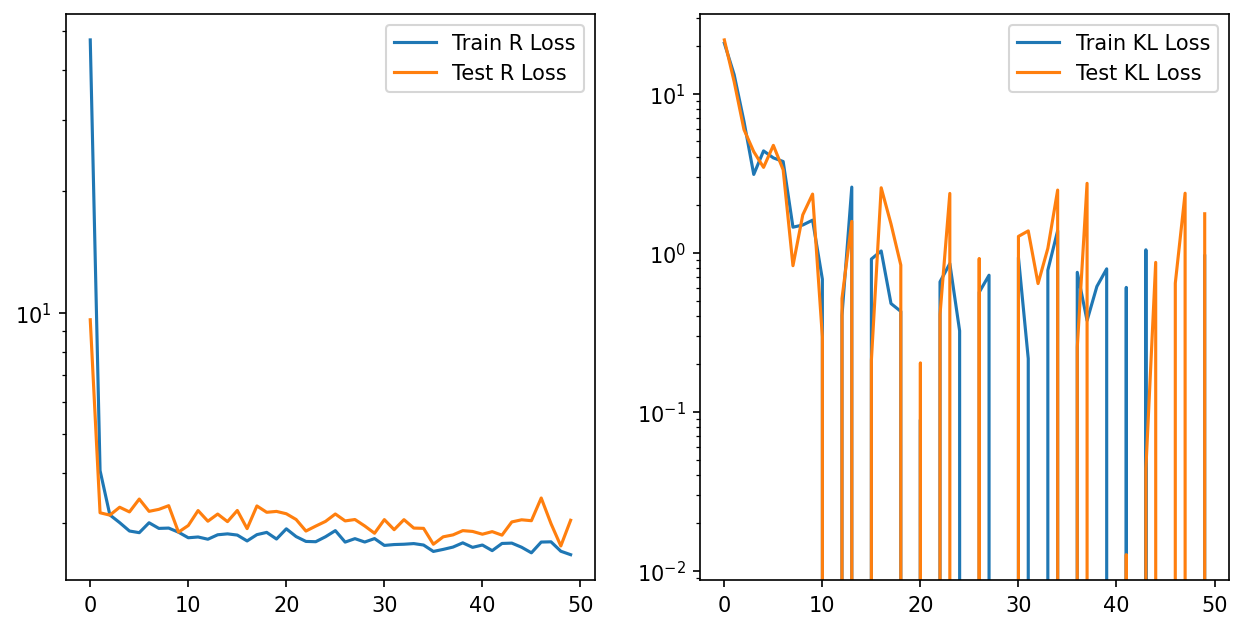

In [1032]:
plt.figure(figsize=(10, 5), dpi=150)

plt.subplot(121)
plt.plot(train_loss[:,0], label="Train R Loss")
plt.plot(test_loss[:,0], label="Test R Loss")

# plt.ylim(0, 0.1)

plt.legend()
plt.yscale('log')

plt.subplot(122)
plt.plot(train_loss[:,1], label="Train KL Loss")
plt.plot(test_loss[:,1], label="Test KL Loss")

# plt.ylim(0, 0.15)

plt.legend()
plt.yscale('log')

In [1038]:
def gen_z_samples(model, x, y, nsamples=1000):
    
    y = y / params['y_normscale']
    y = tf.tile(y,(nsamples, 1, 1))
    x = tf.tile(x,(nsamples, 1))
    
    mean_r1, logvar_r1, logweight_r1 = model.encode_r1(y=y)
    
    scale_r1 = EPS + tf.sqrt(tf.exp(logvar_r1))
    
    gm_r1 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r1),
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r1,
            scale_diag=scale_r1))
    
    z_samp_r1 = gm_r1.sample()
    
    mean_q, logvar_q = model.encode_q(x=x,y=y)
    
    scale_q = EPS + tf.sqrt(tf.exp(logvar_q))
    mvn_q = tfp.distributions.MultivariateNormalDiag(
                          loc=mean_q,
                          scale_diag=scale_q)
    
    z_samp_q = mvn_q.sample()    
    
    return mean_r1, z_samp_r1, mean_q, z_samp_q

In [1079]:
def gen_samples(model, y, ramp=1.0, nsamples=100, max_samples=10):    # Generate samples from (test) y.

    y = y
    y = tf.tile(y, (max_samples, 1, 1, 1))
    
    samp_iterations = int(nsamples / max_samples)

    print("samp_iterations", samp_iterations)
    
    x_sample = []
    for i in range(samp_iterations):
        mean_r1, logvar_r1, logweight_r1 = model.encode_r1(y=y) # Encode y to get z.
        scale_r1 = EPS + tf.sqrt(tf.exp(logvar_r1))
        
        gm_r1 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r1),
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r1,
            scale_diag=scale_r1))
        
        z_samp = gm_r1.sample()   # Sample a z_samp.
        
        mean_r2, logvar_r2, logweight_r2 = model.decode_r2(z=z_samp,y=y)  # Decode (z_samp, y) => x
        scale_r2 = EPS + tf.sqrt(tf.exp(logvar_r2))
        
        gm_r2 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r2),    
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r2,
            scale_diag=scale_r2))

        current_sample = gm_r2.sample()
        current_sample_inverse_transformed = x_scaler.inverse_transform(current_sample)

        if i == 0:
            x_sample = current_sample_inverse_transformed   # Sample an x.
        else:
            x_sample = tf.concat([x_sample, current_sample_inverse_transformed],axis=0)


    return x_sample


In [1080]:
bounds = {'frequency_min': 0, 'frequency_max': 50}

defaults_kwargs = dict(
                    bins=50, smooth=0.9, label_kwargs=dict(fontsize=16),
                    title_kwargs=dict(fontsize=16),
                    truth_color='#4682b4', quantiles=[0.16, 0.84],
                    levels=(0.68,0.90,0.95), density=True,
                    plot_density=False, plot_datapoints=True,
                    max_n_ticks=3)


hist_kwargs = dict(density=True,color='tab:red')
hist_kwargs_other = dict(density=True,color='tab:blue')

In [1081]:
plot_dir = "./"
params['n_samples'] = 100

run = plot_dir

In [1082]:
params['corner_labels'] = {'frequency': 'frequency', 'fdot': 'fdot'}

In [1127]:
def generate_posterior(dataset):

  for step, (x_batch, y_batch) in dataset.enumerate():

      samples = gen_samples(model, y_batch, ramp=ramp, nsamples=params['n_samples'])

      print('Epoch: {}, run {} Testing time elapsed for {} samples.'.format(epoch,run,params['n_samples']))

      # print(np.mean(samples), np.mean(x_truth))
      # print(samples)

      # x_truth = x_scaler.inverse_transform(x_batch)
      x_truth = np.expand_dims(x_scaler.inverse_transform(x_batch[:,:,0]), -1)

      # tf.reduce_mean(x_truth[:,:,0], axis=(0))

      sample_mean = tf.math.reduce_mean(samples, axis=0)
      sample_std = tf.math.reduce_std(samples, axis=0)
      x_truth_mean = tf.math.reduce_mean(x_truth[:,:,0], axis=0)
      x_truth_std = tf.math.reduce_std(x_truth[:,:,0], axis=0)

      # print(type(sample_mean), type(x_truth_mean))
      # diff = 100 * np.abs(sample_mean - x_truth_mean) / x_truth_mean
      diff = -1

      # print("Mean of sample = %.2f (%.2f); mean of truth = %.2f (%.2f); difference = %.2f percent." % (sample_mean, sample_std, x_truth_mean, x_truth_std, diff))
      
      print("Mean of sample = ", end="\t")
      print(sample_mean)
      print(" x truth mean = ", end="\t")
      print(x_truth_mean)
      print(" diff = ", end="\t")
      print(diff)
      

      # print(params['corner_labels'])
      # Get corner parnames to use in plotting labels
      parnames = []
      for k_idx, k in enumerate(params['rand_pars']):
          # print(k_idx, k)
          if np.isin(k, params['inf_pars']):
              parnames.append(params['corner_labels'][k])

      full_true_x = np.zeros(x_truth.shape[1:])
      new_samples = np.zeros([samples.shape[0], len(params['inf_pars'])])

      # print(full_true_x.shape)
      # print(x_truth[0].shape)
      for inf_par_idx, inf_par in enumerate(params['inf_pars']):
          new_samples[:,inf_par_idx] = samples[:,inf_par_idx]
          full_true_x[inf_par_idx] = x_truth[0, inf_par_idx, 0]
      
  #     plt.subplot(width, height, step + 1)
      figure = corner.corner(new_samples, **defaults_kwargs,labels=parnames,
                        color='tab:red',
                        fill_contours=True, truths=full_true_x[:,0],
                        show_titles=True, hist_kwargs=hist_kwargs)

samp_iterations 10
Epoch: 50, run ./ Testing time elapsed for 100 samples.
Mean of sample = 	tf.Tensor([3.00216955e+00 2.04427307e-07], shape=(2,), dtype=float64)
 x truth mean = 	tf.Tensor([3.00463498e+00 3.12149050e-07], shape=(2,), dtype=float64)
 diff = 	-1
samp_iterations 10
Epoch: 50, run ./ Testing time elapsed for 100 samples.
Mean of sample = 	tf.Tensor([3.00050350e+00 1.74777598e-07], shape=(2,), dtype=float64)
 x truth mean = 	tf.Tensor([2.99638727e+00 9.25971089e-08], shape=(2,), dtype=float64)
 diff = 	-1
samp_iterations 10
Epoch: 50, run ./ Testing time elapsed for 100 samples.
Mean of sample = 	tf.Tensor([3.00036868e+00 1.41330717e-07], shape=(2,), dtype=float64)
 x truth mean = 	tf.Tensor([ 2.99827011e+00 -8.68278755e-08], shape=(2,), dtype=float64)
 diff = 	-1
samp_iterations 10
Epoch: 50, run ./ Testing time elapsed for 100 samples.
Mean of sample = 	tf.Tensor([3.00065984e+00 1.81972918e-07], shape=(2,), dtype=float64)
 x truth mean = 	tf.Tensor([2.99362513e+00 2.6335

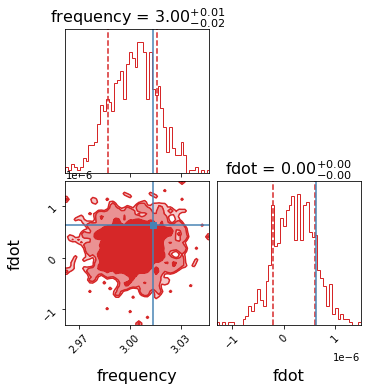

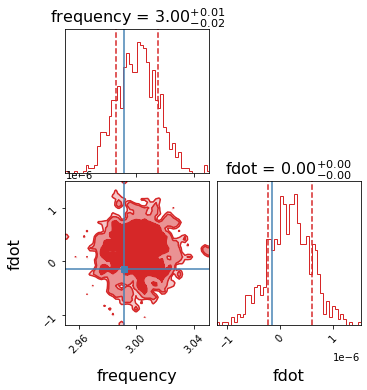

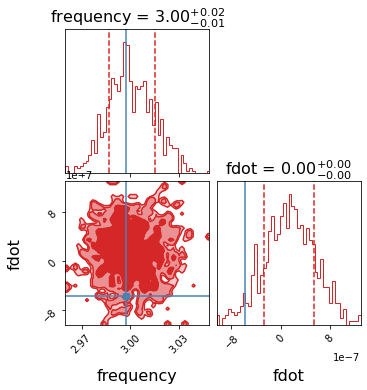

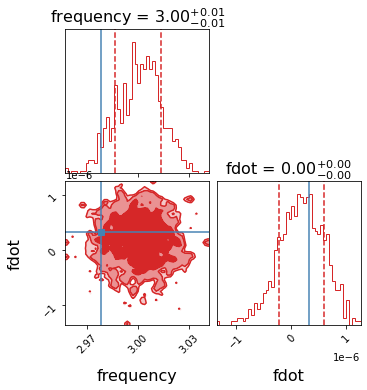

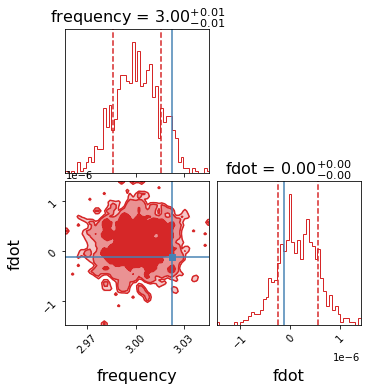

In [1128]:
generate_posterior(train_dataset)

samp_iterations 10
Epoch: 50, run ./ Testing time elapsed for 100 samples.
Mean of sample = 	tf.Tensor([3.00001847e+00 2.19273839e-07], shape=(2,), dtype=float64)
 x truth mean = 	tf.Tensor([3.00692532e+00 2.17440068e-07], shape=(2,), dtype=float64)
 diff = 	-1


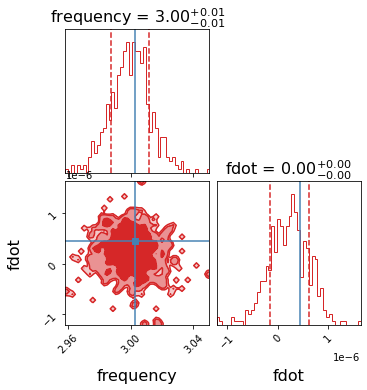

In [1129]:
generate_posterior(test_dataset)

In [1126]:
x_truth

<tf.Tensor: shape=(2, 2, 1), dtype=float32, numpy=
array([[[ 1.9991537e+01],
        [-2.8287377e-07]],

       [[ 2.0020668e+01],
        [ 1.2588627e-07]]], dtype=float32)>

In [1114]:
np.expand_dims(x_scaler.inverse_transform(x_truth[:,:,0]), -1)

array([[[3.31436913e+00],
        [1.27789631e-07]],

       [[3.31482923e+00],
        [1.27789819e-07]]])

In [1123]:
tf.math.reduce_mean(x_truth[:,:,0], axis=0)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 2.0006104e+01, -7.8493748e-08], dtype=float32)>

<tf.Tensor: shape=(2, 2, 1), dtype=float32, numpy=
array([[[ 1.9991537e+01],
        [-2.8287377e-07]],

       [[ 2.0020668e+01],
        [ 1.2588627e-07]]], dtype=float32)>